In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.stats import pearsonr

In [27]:
gene_1=pd.read_csv('data/gene_1.txt',delimiter='\t', low_memory=False)

In [28]:
gene_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Columns: 1449 entries, Sample to Expression
dtypes: float64(1448), object(1)
memory usage: 8.6+ MB


In [29]:
gene_1.head()

,Sample,15-45976702-45977052,15-45982813-45983160,15-45983175-45983347,15-45995910-45996255,15-45996259-45996428,15-45996456-45996764,15-45996819-45996987,15-45997063-45997254,15-45997416-45997635,...,15-49315529-49315877,15-49381258-49381604,15-50167700-50167901,15-50315097-50315414,15-50347957-50348141,15-50479039-50479260,15-48103367-48103714,15-49414124-49414471,15-49938148-49938496,Expression
0,IHECRE00001955,0.49830,0.71765,1.26255,0.21368,0.85358,0.63976,0.33459,0.00000,0.44695,...,0.63570,2.50192,0.76997,0.48920,0.48993,0.78117,1.52976,1.38009,0.34980,0.0
1,IHECRE00000227,2.92223,2.66952,2.69382,0.72047,0.46327,0.04019,0.34007,0.14549,4.55700,...,0.07586,0.70405,0.80722,0.00000,0.29017,0.74775,2.92270,1.44552,2.42589,0.0
2,IHECRE00001478,0.43758,0.32964,1.62194,0.31023,1.32639,1.71436,1.44638,2.78841,2.27327,...,2.04935,1.37250,1.03671,1.56793,2.95682,0.28493,0.90301,0.52811,1.60139,0.0
3,IHECRE00002337,2.23747,2.68867,0.73725,1.34511,2.90871,1.64011,0.71892,0.08026,0.46206,...,0.96743,0.12732,0.51818,2.09059,2.24160,0.58484,1.78445,0.79445,1.14262,0.0
4,IHECRE00001236,0.32554,0.49021,0.72664,3.13590,1.32609,1.42868,2.00968,1.87176,2.91399,...,0.45535,0.65087,1.82249,0.02572,0.77713,0.83902,2.72411,0.73362,0.91528,0.0


## Conversion to TPM, Log2 transform and investigate effect on distribution

Data is in FPKM (insert source). We should convert to TPM because we learned that it's better. 

Additionally we will log2(x+1) transform, because apparently that's best practise to get closer to the assumption of normal distributedness needed for linear regression, etc., see for example https://montilab.github.io/BS831/articles/docs/RNAseq_ScalNorm.html

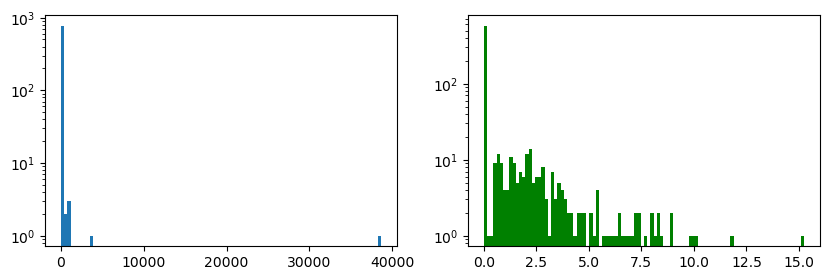

In [69]:
fig, axs=plt.subplots(1,2,figsize=(10,3))
axs[0].hist(gene_1['Expression'],bins=100)
axs[0].set_yscale('log')
axs[1].hist(np.log2(gene_1['Expression']+1), bins=100, color='g')
axs[1].set_yscale('log')
plt.show()

In [70]:
# log2 transform
gene_1['Expression']=np.log2(gene_1['Expression']+1)

## Splitting into training and test data for further analysis

In [108]:
X_train, X_test, Y_train, Y_test, idx_train, idx_test = sk.model_selection.train_test_split(gene_1.iloc[:,0:-1], gene_1.iloc[:,-1], np.arange(len(gene_1['Expression'])), test_size=0.3)

In [109]:
# convert everything to numpy arrays 
X_train_np=X_train.iloc[:,1:].to_numpy()
X_test_np=X_test.iloc[:,1:].to_numpy()
Y_train_np=Y_train.to_numpy()
Y_test_np=Y_test.to_numpy()

In [110]:
# z-score data
x_scaler=sk.preprocessing.StandardScaler()
y_scaler=sk.preprocessing.StandardScaler()

In [111]:
X_train_np=x_scaler.fit_transform(X_train_np)
X_test_np=x_scaler.transform(X_test_np)
Y_train_np=y_scaler.fit_transform(Y_train_np.reshape(-1,1))[:,0]
Y_test_np=y_scaler.transform(Y_test_np.reshape(-1,1))[:,0]

## Principal component analysis

We do this to check two things:

- do samples cluster by expression or not
- can we obtain the same or even improved accuary by using PCA as a feature selection method

In [112]:
PCA=sk.decomposition.PCA()

In [113]:
X_trans=PCA.fit_transform(X_train_np)

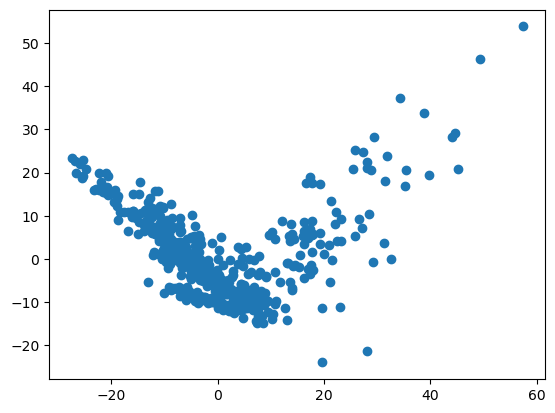

In [114]:
plt.scatter(X_trans[:,0], X_trans[:,1])

In [115]:
expl_var_ratio=PCA.explained_variance_ratio_

Text(0, 0.5, 'explained variance')

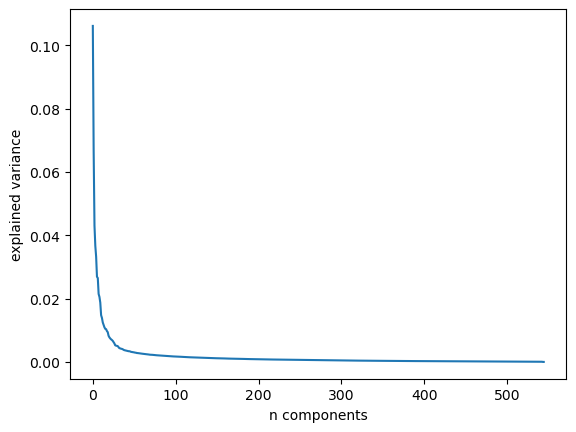

In [116]:
plt.plot(expl_var_ratio)
plt.xlabel("n components")
plt.ylabel("explained variance")
#plt.xlim(0,100)

In [117]:
print(expl_var_ratio[0:20])

[0.10608262 0.06682127 0.04304321 0.03664417 0.03321392 0.02690376
 0.0264781  0.02146541 0.02051726 0.01871754 0.01475434 0.01390215
 0.0124661  0.01173645 0.0109426  0.01043342 0.01035541 0.00974476
 0.00940011 0.00825153]


Judging from this, it might be enough to keep only the first 20 principal components since the others explain less than 1% of variance.

In [191]:
X_pca=X_trans[:,0:20]

In [192]:
exp_or_not=gene_1.iloc[idx_train,-1]
exp_or_not=exp_or_not>0
print(len(exp_or_not))

545


Text(0, 0.5, 'PC 2')

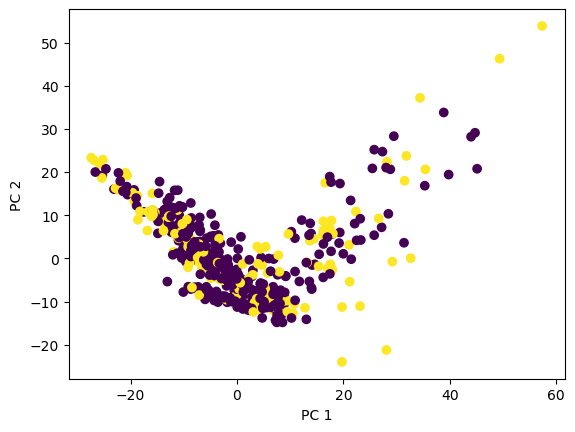

In [193]:
plt.scatter(X_pca[:,0], X_pca[:,1],c=exp_or_not)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

Conclusion: no visible clustering by whether the gene is expressed in a sample at all or not.

## 1 Baseline: Elastic net with all features

In [124]:
param_grid = {
 "alpha": [0.01, 0.1, 0.2, 0.5, 1],
 "l1_ratio": [0.5, 0.7, 0.9, 1.0]
}
elastic_net=sk.linear_model.ElasticNet(random_state=42, fit_intercept=False, max_iter=5000)
grid_searcher=sk.model_selection.GridSearchCV(elastic_net, param_grid, scoring='neg_root_mean_squared_error', refit=True, verbose=1)

In [125]:
grid_searcher.fit(X_train_np, Y_train_np)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=ElasticNet(fit_intercept=False, max_iter=5000,
                                  random_state=42),
             param_grid={'alpha': [0.01, 0.1, 0.2, 0.5, 1],
                         'l1_ratio': [0.5, 0.7, 0.9, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [126]:
results=grid_searcher.cv_results_

In [127]:
df=pd.DataFrame(results)
df=df[['mean_fit_time', 'param_alpha', 'param_l1_ratio', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [128]:
df.sort_values('rank_test_score', axis=0)

,mean_fit_time,param_alpha,param_l1_ratio,mean_test_score,std_test_score,rank_test_score
4,0.012805,0.10,0.5,-0.806217,0.114579,1
5,0.010679,0.10,0.7,-0.817661,0.121098,2
6,0.010274,0.10,0.9,-0.826263,0.124617,3
8,0.010863,0.20,0.5,-0.829603,0.126606,4
7,0.011328,0.10,1.0,-0.831527,0.125209,5
9,0.009403,0.20,0.7,-0.857231,0.128487,6
10,0.009176,0.20,0.9,-0.883228,0.129867,7
3,0.039724,0.01,1.0,-0.891399,0.099962,8
2,0.042520,0.01,0.9,-0.895956,0.097595,9
11,0.008823,0.20,1.0,-0.896352,0.129172,10


In [220]:
best_estimator=grid_searcher.best_estimator_

In [226]:
# to see how many nonzero coefficients remain
print(np.sum(best_estimator.coef_!=0))
print(len(best_estimator.coef_))

100
1447


In [130]:
Y_pred = best_estimator.predict(X_test_np)

In [131]:
elastic_net_score=best_estimator.score(X_test_np, Y_test_np)
print(elastic_net_score)

0.3758092112330209


In [132]:
MSE=sk.metrics.mean_squared_error(Y_test_np, Y_pred)

In [133]:
print(MSE)

0.5847839663099592


Text(0.5, 0, 'sample idx')

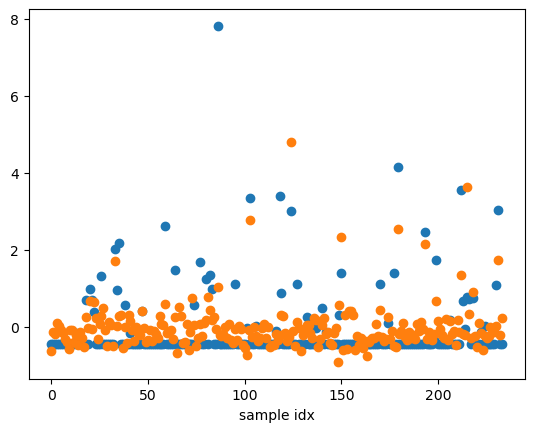

In [140]:
plt.scatter(np.arange(len(Y_test_np)),Y_test_np, label='Y_test')
plt.scatter(np.arange(len(Y_pred)),Y_pred, label='Y_pred')
plt.xlabel('sample idx')

Text(0, 0.5, 'Y_pred')

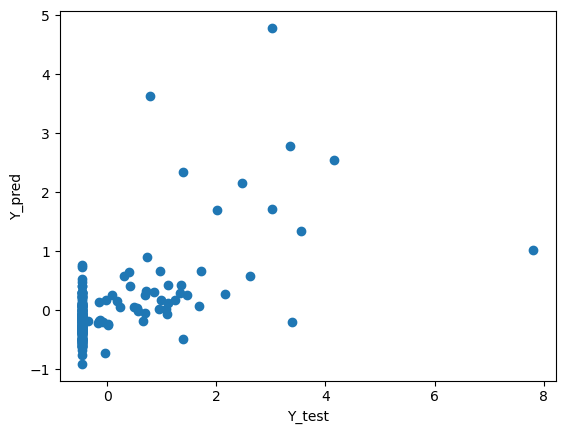

In [141]:
plt.scatter(Y_test_np,Y_pred)
plt.xlabel('Y_test')
plt.ylabel('Y_pred')

In [145]:
elastic_net_corr=pearsonr(Y_test_np, Y_pred)
print(elastic_net_corr)

PearsonRResult(statistic=0.6175878053725099, pvalue=5.338540938401309e-26)


## 2 Elastic net with first 20 PCs

In [194]:
elastic_net_2=sk.linear_model.ElasticNet(random_state=42, fit_intercept=False, max_iter=5000)
grid_searcher_2=sk.model_selection.GridSearchCV(elastic_net_2, param_grid, scoring='neg_root_mean_squared_error', refit=True, verbose=1)

In [195]:
grid_searcher_2.fit(X_pca, Y_train_np)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=ElasticNet(fit_intercept=False, max_iter=5000,
                                  random_state=42),
             param_grid={'alpha': [0.01, 0.1, 0.2, 0.5, 1],
                         'l1_ratio': [0.5, 0.7, 0.9, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [196]:
best_estimator_2=grid_searcher_2.best_estimator_

In [197]:
results=grid_searcher_2.cv_results_

In [198]:
df=pd.DataFrame(results)
df=df[['mean_fit_time', 'param_alpha', 'param_l1_ratio', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [199]:
df.sort_values('rank_test_score', axis=0)

,mean_fit_time,param_alpha,param_l1_ratio,mean_test_score,std_test_score,rank_test_score
9,0.000484,0.20,0.7,-0.847809,0.124988,1
10,0.000495,0.20,0.9,-0.848383,0.126227,2
11,0.000537,0.20,1.0,-0.849121,0.126826,3
8,0.000704,0.20,0.5,-0.849207,0.123996,4
7,0.000625,0.10,1.0,-0.849522,0.123871,5
6,0.000500,0.10,0.9,-0.850530,0.123412,6
12,0.000579,0.50,0.5,-0.853543,0.127662,7
5,0.000641,0.10,0.7,-0.856569,0.119956,8
13,0.000487,0.50,0.7,-0.864700,0.127814,9
4,0.000678,0.10,0.5,-0.872606,0.112662,10


In [200]:
X_test_pca=PCA.transform(X_test_np)
X_test_pca=X_test_pca[:,0:20]

In [201]:
Y_pred = best_estimator_2.predict(X_test_pca)

In [202]:
elastic_net_score=best_estimator.score(X_test_np, Y_test_np)
print(elastic_net_score)

0.3758092112330209


In [203]:
MSE=sk.metrics.mean_squared_error(Y_test_np, Y_pred)
print(MSE)

0.6002302818739217


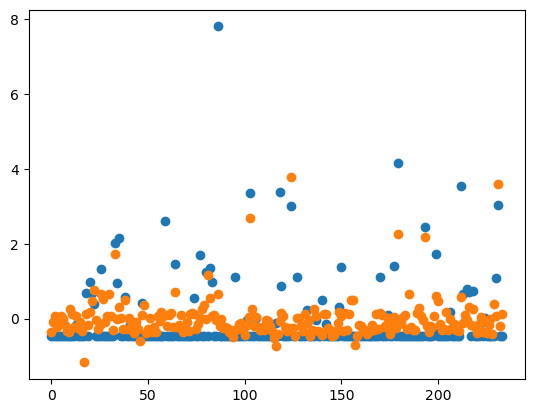

In [204]:
plt.scatter(np.arange(len(Y_test_np)),Y_test_np)
plt.scatter(np.arange(len(Y_pred)),Y_pred)

Conclusion: slightly worse performance keeping only the first 20 PCs but difference is so small that it might be worth investigating as a feature selection method for training with neural networks.

## Gradient boosting

In [205]:
gb_regressor=sk.ensemble.GradientBoostingRegressor()

In [206]:
gb_regressor.fit(X_train_np, Y_train_np)

GradientBoostingRegressor()

In [207]:
Y_pred=gb_regressor.predict(X_test_np)

In [208]:
gb_score=gb_regressor.score(X_test_np,Y_test_np)
print(gb_score)

0.39665319159551604


In [209]:
gb_MSE=sk.metrics.mean_squared_error(Y_test_np,Y_pred)

In [210]:
print(gb_MSE)

0.5652559217930813


In [211]:
from scipy.stats import pearsonr

In [212]:
gb_corr=pearsonr(Y_test_np, Y_pred)
print(gb_corr)

PearsonRResult(statistic=0.6355606125062957, pvalue=7.026519294582623e-28)


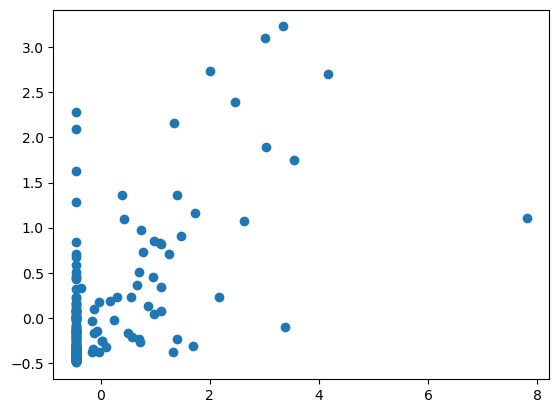

In [213]:
plt.scatter(Y_test_np,Y_pred)

Conclusion: gradient boosting does slighlty better than elastic net, definitely worth investigating in controlled experiments, other nonlinear/distribution-distribution free methods.

## Hyperparameter tuning on gradient boosting

In [222]:
param_grid = {
 "learning_rate": [0.05, 0.1, 0.2],
 "n_estimators": [100, 200],
 "max_depth": [1, 5, 10, 20, 50]
}
gb_regressor=sk.ensemble.GradientBoostingRegressor()
grid_searcher=sk.model_selection.GridSearchCV(gb_regressor, param_grid, scoring='neg_root_mean_squared_error', refit=True, verbose=1)

In [223]:
'''
CAUTION, executing this cell took me 3 hours to finish, 
for best model, see txt file with parameters in results folder
'''

grid_searcher.fit(X_train_np, Y_train_np)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [1, 5, 10, 20, 50],
                         'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [225]:
results=grid_searcher.cv_results_

In [229]:
df=pd.DataFrame(results)
df=df[['mean_fit_time', 'param_learning_rate', 'param_n_estimators', 'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [230]:
df.sort_values('rank_test_score', axis=0)

,mean_fit_time,param_learning_rate,param_n_estimators,param_max_depth,mean_test_score,std_test_score,rank_test_score
11,17.969527,0.10,200,1,-0.795088,0.146948,1
21,17.819259,0.20,200,1,-0.799656,0.121655,2
10,8.975750,0.10,100,1,-0.802273,0.155772,3
20,8.902929,0.20,100,1,-0.802921,0.131889,4
1,17.792244,0.05,200,1,-0.804657,0.158749,5
2,41.933173,0.05,100,5,-0.822682,0.140867,6
13,82.882891,0.10,200,5,-0.829506,0.147913,7
22,41.324711,0.20,100,5,-0.830002,0.123190,8
23,80.798228,0.20,200,5,-0.830726,0.103984,9
12,41.970580,0.10,100,5,-0.831275,0.147948,10


In [231]:
best_estimator=grid_searcher.best_estimator_

In [232]:
Y_pred=best_estimator.predict(X_test_np)

In [234]:
score=best_estimator.score(X_test_np, Y_test_np)
print(score)

0.47975592507857645


In [235]:
MSE=sk.metrics.mean_squared_error(Y_pred, Y_test_np)
print(MSE)

0.7541531720111655


In [237]:
corr_coeff=pearsonr(Y_test_np,Y_pred)
print(corr_coeff)

PearsonRResult(statistic=0.7063495264462067, pvalue=1.1379241282363749e-36)


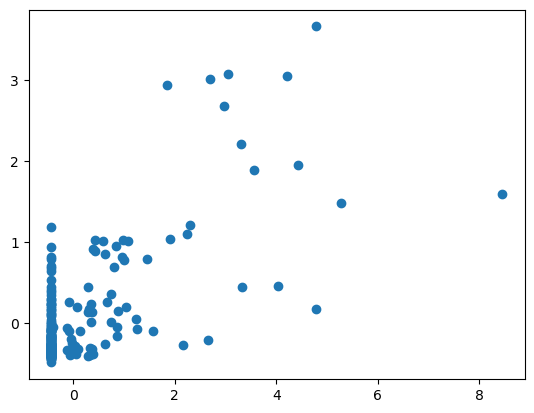

In [239]:
plt.scatter(Y_test_np,Y_pred)

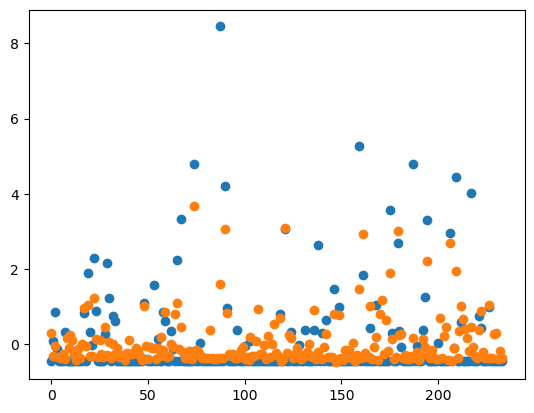

In [240]:
plt.scatter(np.arange(len(Y_test_np)),Y_test_np)
plt.scatter(np.arange(len(Y_pred)), Y_pred)

In [ ]:
df.to_csv('../results/gradient_boost_gridsearchcv.txt', sep='\t')

## K-means clustering

To see whether there are obvious clusters and it might be worth trying a mixture-of-experts-model

In [214]:
k_means=sk.cluster.KMeans(n_clusters=3)

In [215]:
clusters=k_means.fit_predict(Y_train_np.reshape(-1,1))

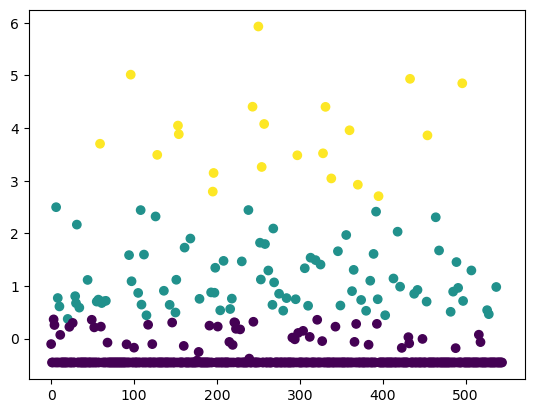

In [216]:
plt.scatter(np.arange(len(Y_train_np)),Y_train_np,c=clusters)

In [217]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping2 = {}
K = range(1, 10)

for k in K:
    kmeanModel = sk.cluster.KMeans(n_clusters=k, random_state=42).fit(Y_train_np.reshape(-1,1))  
    inertias.append(kmeanModel.inertia_)
    mapping2[k] = inertias[-1]

Inertia values:
1 : 545.0000000000002
2 : 151.18137766665635
3 : 52.689274819229865
4 : 26.580166286571007
5 : 18.46306719393407
6 : 13.016751668439793
7 : 8.028761684397988
8 : 6.8133696375238415
9 : 5.169651791020109


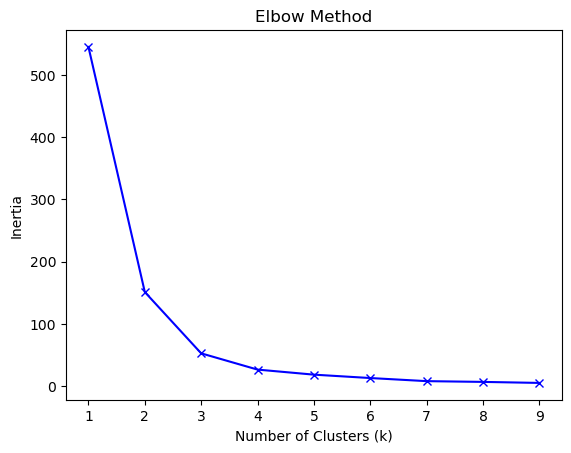

In [219]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()